# Building a Custom CNN for Cat vs. Dog Classification (Regularized VGG16 tuned model)

## Solving VGG16 Overfitting with Data Augmentation & Fine-Tuning
### Our previous model showed clear signs of overfitting: high training accuracy but a plateaued (or even decreasing) validation accuracy.

**We will combat this using two primary techniques:**

**Data Augmentation:** We'll use ImageDataGenerator to apply random transformations (rotations, zooms, flips) to our training images. This artificially expands our dataset, teaching the model to be more robust to variations.

**Fine-Tuning:** We will unfreeze the top convolutional block of the VGG16 base (block5_...). This allows the model to adapt its high-level feature extraction (which was trained on ImageNet) to the specific features of cats and dogs. We will also add a Dropout layer for regularization.


## Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

tf.__version__

'2.19.0'

## Preprocessing the Training Set and Test Set

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"✅ Found {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f"   {gpu.name}")
else:
    print("❌ WARNING: No GPU found. You are running on a CPU.")

✅ Found 1 GPU(s):
   /physical_device:GPU:0


**We apply rescaling from 0-255 to 0-1, shear transformation(tilt), zoom transformation and horizontal flip to prevent overfitting**

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255) #We only apply rescale to our test set

## Importing the training and test set

In [4]:
import time

print("Unzipping dataset...")
start_time = time.time()

!unzip -q "/content/dataset.zip" -d "/content/dataset"

end_time = time.time()
print(f"✅ Unzipping complete in {end_time - start_time:.2f} seconds.")
training_set=train_datagen.flow_from_directory('/content/dataset/dataset/training_set',target_size=(128,128),batch_size=32,class_mode='binary')
test_set=test_datagen.flow_from_directory('/content/dataset/dataset/test_set',target_size=(128,128),batch_size=32,class_mode='binary')

Unzipping dataset...
✅ Unzipping complete in 3.22 seconds.
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Visualizing couple of images

{'cats': 0, 'dogs': 1}


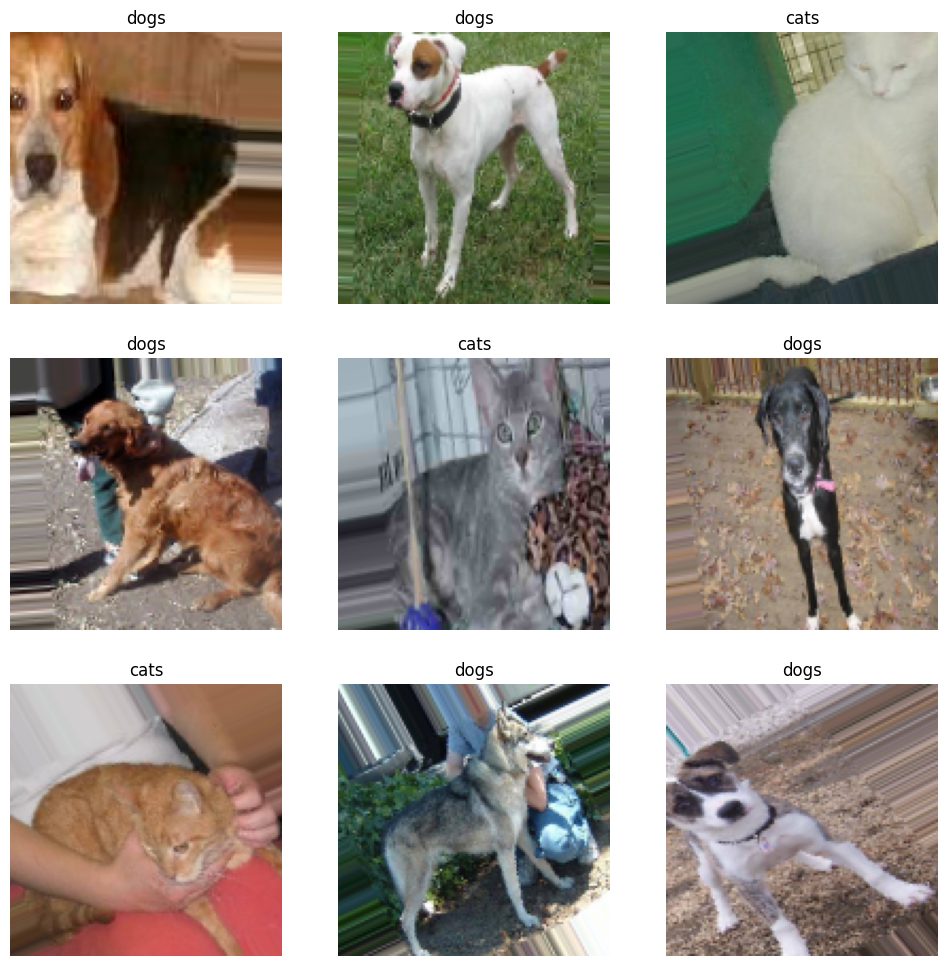

In [25]:
images,labels=next(training_set)
print(training_set.class_indices)
class_names=list(training_set.class_indices.keys())

plt.figure(figsize=(12,12))
for i in range(9):
    grid=plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    label_index=int(labels[i])
    plt.title(class_names[label_index])
    plt.axis("off")
plt.show()

## Building the CNN and adding dropout layers

In [5]:
vgg=VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))
# Freezing the base
vgg.trainable=False
cnn=tf.keras.models.Sequential()
cnn.add(vgg)
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(128,activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(tf.keras.layers.Dense(1,activation='sigmoid'))



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## Training the CNN and implementing early stopping

In [6]:
steps_per_epoch=int(training_set.samples/32)
validation_steps=int(test_set.samples/32)
print(f"Train steps per epoch:{steps_per_epoch}")
print(f"Validation steps per epoch:{validation_steps}")
early_stopper=EarlyStopping(monitor='val_loss',min_delta=0.00,patience=3,verbose=1,mode='auto',restore_best_weights=True)
cnn.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])
history=cnn.fit(training_set,steps_per_epoch=steps_per_epoch,epochs=30,validation_data=test_set,validation_steps=validation_steps,callbacks=[early_stopper])

Train steps per epoch:250
Validation steps per epoch:62


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - accuracy: 0.6776 - loss: 0.5938 - val_accuracy: 0.8543 - val_loss: 0.3380
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - accuracy: 0.8126 - loss: 0.4150 - val_accuracy: 0.8629 - val_loss: 0.3044
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.8212 - loss: 0.3887 - val_accuracy: 0.8775 - val_loss: 0.2875
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.8279 - loss: 0.3708 - val_accuracy: 0.8760 - val_loss: 0.2861
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - accuracy: 0.8368 - loss: 0.3700 - val_accuracy: 0.8780 - val_loss: 0.2820
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 198ms/step - accuracy: 0.8375 - loss: 0.3625 - val_accuracy: 0.8649 - val_loss: 0.3007
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 202ms/step - accuracy: 0.8327 - loss: 0.3624 - val_accuracy: 0.8785 - val_loss: 0.2675
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.8405 - loss: 0

### Plotting validation loss and accuracy

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8768 - loss: 0.2790

Final Validation Loss:0.27

Final Validation Accuracy:0.88


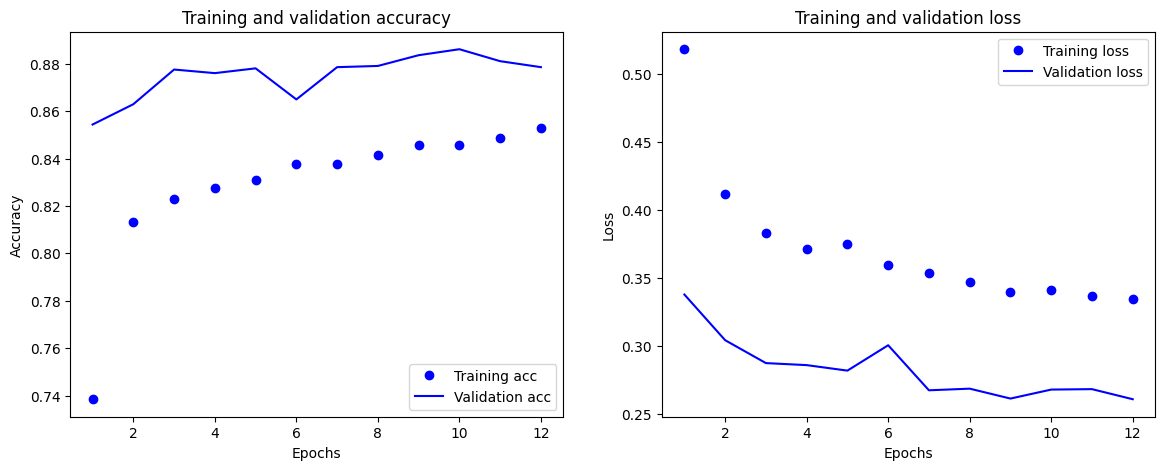

In [7]:
loss,accuracy=cnn.evaluate(test_set,steps=validation_steps)
print(f"\nFinal Validation Loss:{loss:.2f}")
print(f"\nFinal Validation Accuracy:{accuracy:.2f}")

def plot_history(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history.history)

### This is already a great improvement over our previous custom CNN model, However we can make it better by unfreezing the top layers and fine tuning the model

## Fine Tuning the Model

In [8]:

vgg.trainable=True

set_trainable=False
for layer in vgg.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False
print("The VGG layers are now trainable")
cnn.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-5),metrics=['accuracy'])
cnn.summary()

The VGG layers are now trainable


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 8,128,257 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Found {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f"   {gpu.name}")
else:
    print("❌ WARNING: No GPU found by TensorFlow.")
    print("   Training will be *extremely* slow on the CPU.")

✅ Found 1 GPU(s):
   /physical_device:GPU:0


In [ ]:
history_fine=cnn.fit(training_set,steps_per_epoch=250,initial_epoch=12,epochs=30,validation_data=test_set,validation_steps=validation_steps,callbacks=[early_stopper])

Epoch 13/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 206ms/step - accuracy: 0.8426 - loss: 0.3437 - val_accuracy: 0.8982 - val_loss: 0.2425
Epoch 14/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.8741 - loss: 0.2870 - val_accuracy: 0.9052 - val_loss: 0.2084
Epoch 15/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.8960 - loss: 0.2438 - val_accuracy: 0.9189 - val_loss: 0.1987
Epoch 16/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.8965 - loss: 0.2382 - val_accuracy: 0.9204 - val_loss: 0.1949
Epoch 17/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 203ms/step - accuracy: 0.9095 - loss: 0.2226 - val_accuracy: 0.9234 - val_loss: 0.1810
Epoch 18/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.9203 - loss: 0.1948 - val_accuracy: 0.9304 - val_loss: 0.1746
Epoch 19/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.9155 - loss: 0.1945 - val_accuracy: 0.9350 - val_loss: 0.1687
Epoch 20/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.9316 -

## Plotting Results from the fine tuned model

In [14]:
loss, accuracy = cnn.evaluate(test_set, steps=validation_steps)
print(f"\nFinal Validation Loss: {loss:.4f}")
print(f"Final Validation Accuracy: {accuracy*100:.2f}%")

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9419 - loss: 0.1505

Final Validation Loss: 0.1684
Final Validation Accuracy: 93.50%


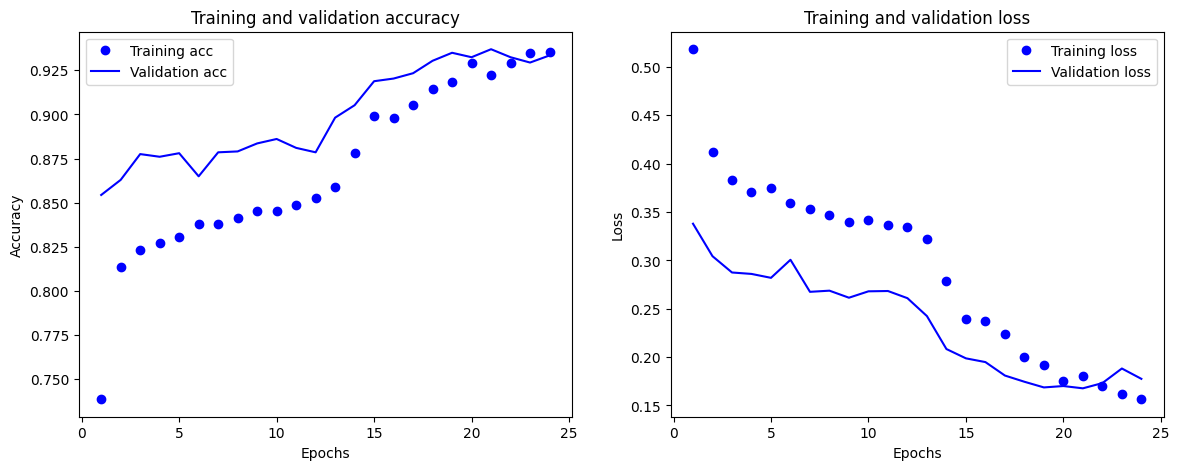

In [11]:
combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine.history[key]

# Plot the combined history
plot_history(combined_history)

## We achieved a much higher accuracy with the fine tuned VGG16 model at 93.5%